![](Zillow.jpg)

# Zillow Clustering Project
# Predicting Logerror of Zestimate
## Natasha Rivers
### June 28, 2021

<hr style="border:2px solid black"> </hr>

## Goals: 
- To find what is driving the errors in the Zillow Zestimate
- 'logerror'= predicted sale value - actual sale value

## Executive Summary:

- 2nd degree Polynomial regression model performed best

| Model                            | rmse_train  | rmse_validate |
|----------------------------------|:-----------:|---------------|
|mean_baseline                     | 0.16529     | 0.17102       |
|OLS                               | 0.16520     | 0.17103       |
|LassoLars (alpha 2)               | 0.16529     | 0.17102       |
|Polynomial Regression (degree=2)  | 0.16512     | 0.17101       |
|OLS (Unscaled Data)               | 0.16520     | 0.17103

<br>

- Clusters have been found between:
    - age of property and number of bedrooms
    - age of property and total square feet of the property
    - longitude and total square feet of the property
    
<br>

- We have failed to reject all four Null Hypothesis
    - Therefore, there is a relationship between these features and logerror



<hr style="border:2px solid black"> </hr>

### Imports

In [1]:
import acquire
import prepare
import explore

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import math

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score


import warnings
warnings.filterwarnings("ignore")

<hr style="border:2px solid black"> </hr>

## Acquire

In [2]:
#function from acquire.py 
zillow = acquire.get_zillow_file()

In [3]:
zillow.head()

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,transactiondate
0,14297519,0.025595,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,96978.0,1998.0,485713.0,1023282.0,537569.0,11013.72,2017-01-01
1,17052889,0.055619,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,97099.0,1967.0,88000.0,464000.0,376000.0,5672.48,2017-01-01
2,14186244,0.005383,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,97078.0,1962.0,85289.0,564778.0,479489.0,6488.30,2017-01-01
3,12177905,-0.103410,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,96330.0,1970.0,108918.0,145143.0,36225.0,1777.51,2017-01-01
4,12095076,-0.001011,3.0,4.0,2962.0,6037.0,34145202.0,-118179824.0,63000.0,96293.0,1950.0,276684.0,773303.0,496619.0,9516.26,2017-01-01


In [4]:
zillow.dtypes

parcelid                          int64
logerror                        float64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
fips                            float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
regionidzip                     float64
yearbuilt                       float64
structuretaxvaluedollarcnt      float64
taxvaluedollarcnt               float64
landtaxvaluedollarcnt           float64
taxamount                       float64
transactiondate                  object
dtype: object

In [5]:
#52916 entries,16 columns, several nulls, incorrect dtypes
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52916 entries, 0 to 52915
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52916 non-null  int64  
 1   logerror                      52916 non-null  float64
 2   bathroomcnt                   52916 non-null  float64
 3   bedroomcnt                    52916 non-null  float64
 4   calculatedfinishedsquarefeet  52814 non-null  float64
 5   fips                          52916 non-null  float64
 6   latitude                      52916 non-null  float64
 7   longitude                     52916 non-null  float64
 8   lotsizesquarefeet             52513 non-null  float64
 9   regionidzip                   52889 non-null  float64
 10  yearbuilt                     52781 non-null  float64
 11  structuretaxvaluedollarcnt    52820 non-null  float64
 12  taxvaluedollarcnt             52915 non-null  float64
 13  l

In [6]:
zillow.shape

(52916, 16)

## Takeaways from Acquire:

- This is a fairly large dataset (2.89M entries)
    - creating a function to save 'get_zillow' into a csv will drastically reduce time to import

<br>

- The data chosen is based somewhat on personal interpretation, different "propertylandusetypeid" may be used 
    - data dictionary with id types I used is available in my README
    
<br>

- The data I chose to work with has:
    - 52,916 entries
    - 16 different columns
    - appear to have some nulls (further explore this in prepare)

<hr style="border:2px solid black"> </hr>

## Prepare

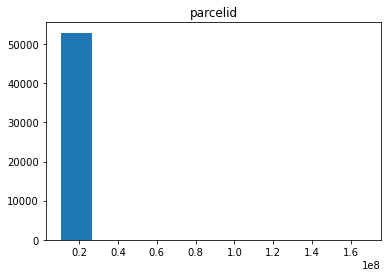

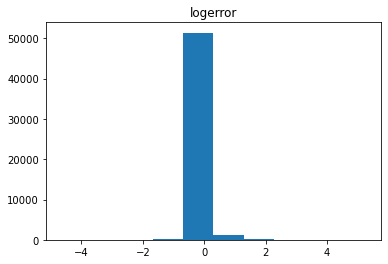

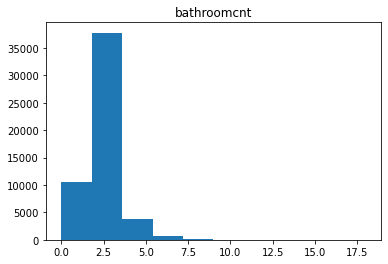

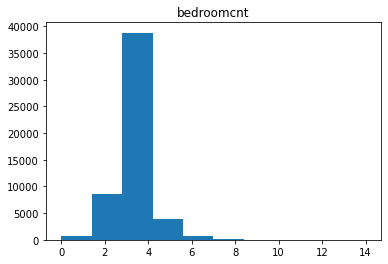

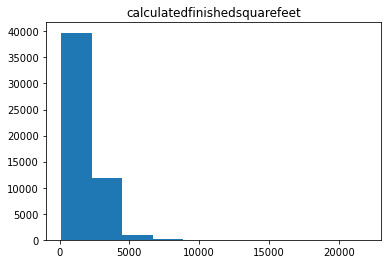

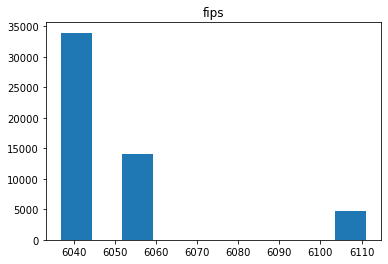

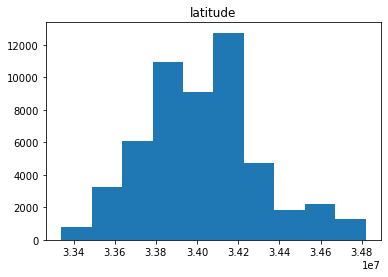

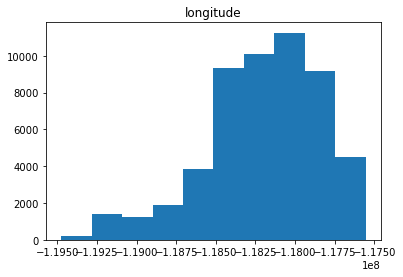

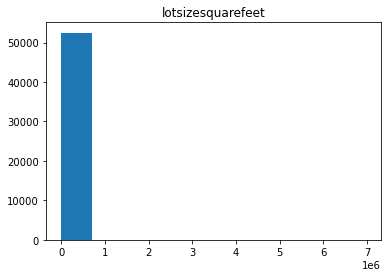

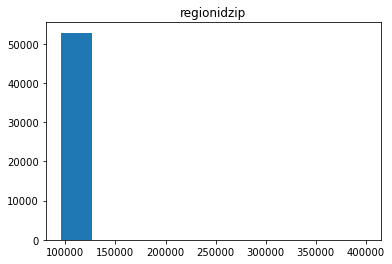

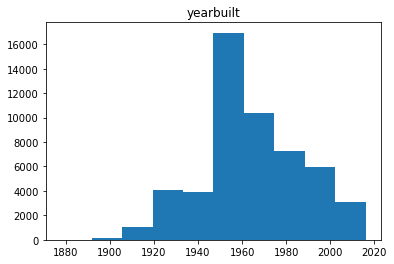

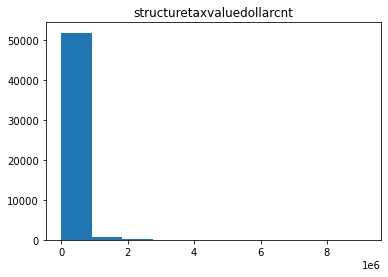

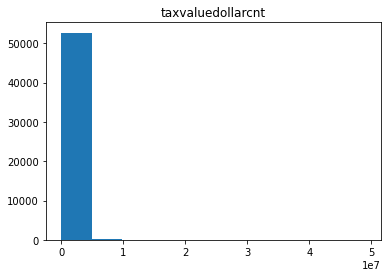

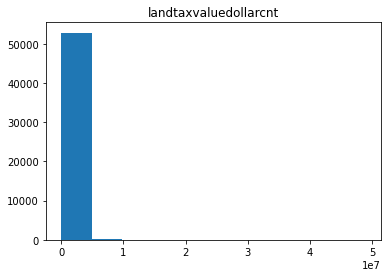

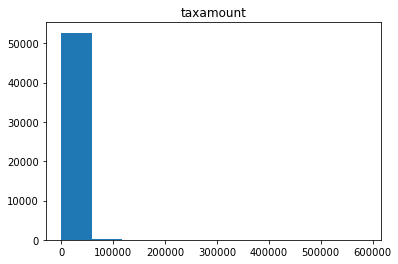

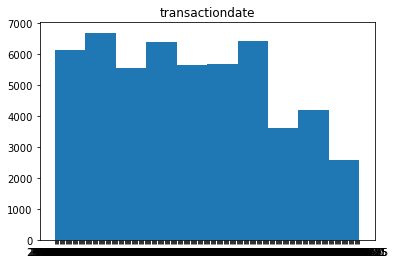

In [7]:
#visualize distributions 
#check for outliers
#visualize distribution
for col in zillow.columns:
    plt.hist(zillow[col])
    plt.title(col)
    plt.show()

______________

### Take a look at outliers:

In [8]:
#function that identifies outliers from prepare.py
prepare.outlier_bound_calculation(zillow, 'bedroomcnt')

For bedroomcnt the lower bound is 1.5 and  upper bound is 5.5


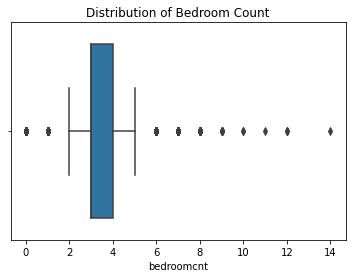

In [9]:
#specifically visualize outliers in bedroom
#thoughts: I need to impute or drop these outliers
sns.boxplot(zillow.bedroomcnt)
plt.title('Distribution of Bedroom Count')
plt.show()

In [10]:
#function that identifies outliers from prepare.py
prepare.outlier_bound_calculation(zillow, 'bathroomcnt')

For bathroomcnt the lower bound is 0.5 and  upper bound is 4.5


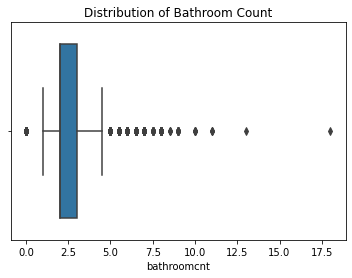

In [11]:
#visualize the same data as above
sns.boxplot(zillow.bathroomcnt)
plt.title('Distribution of Bathroom Count')
plt.show()

## Takeaways from Outliers:
- I will use 'remove_outliers' function from prepare.py to remove outliers that were outside upper_bound (.75) and lower_bound (.25) of IQR

____________

### Take a look at Nulls:

In [12]:
#look at null values
zillow.isnull().sum()

parcelid                          0
logerror                          0
bathroomcnt                       0
bedroomcnt                        0
calculatedfinishedsquarefeet    102
fips                              0
latitude                          0
longitude                         0
lotsizesquarefeet               403
regionidzip                      27
yearbuilt                       135
structuretaxvaluedollarcnt       96
taxvaluedollarcnt                 1
landtaxvaluedollarcnt             2
taxamount                         4
transactiondate                   0
dtype: int64

In [13]:
#take a look at how many nulls there are by row
explore.nulls_by_col(zillow)

,num_rows_missing,pct_rows_missing
parcelid,0,0.000000
logerror,0,0.000000
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000
calculatedfinishedsquarefeet,102,0.192758
fips,0,0.000000
latitude,0,0.000000
longitude,0,0.000000
lotsizesquarefeet,403,0.761584
regionidzip,27,0.051024


In [14]:
#take a look at how many nulls there are by row
explore.nulls_by_row(zillow)

,num_cols_missing,pct_cols_missing,num_rows
0,0,0.0,52305
1,1,6.25,484
2,2,12.5,100
3,3,18.75,24
4,4,25.0,1
5,5,31.25,2


### Takeaways from nulls:

- I will drop null values that fall outside the threshold using 'handling_missing_values' function (.5,.5) from prepare.py
- I will impute the rest of the missing values that were note dropped

________

In [15]:
#function from prepare.py that changes column names, changes dtypes, 
#imputes values, drop nulls and outliers, creates new column with county name

zillow = prepare.final_prep_zillow(zillow)

In [16]:
#as you can see.. column names have been changed
zillow.head()

,parcelid,logerror,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,county,property_age
0,14297519,0.025595,3.5,4,3100,6059,33634931,-117869207,4506,96978,1998,485713,1023282,537569,11013,20170101,orange,19
1,17052889,0.055619,1.0,2,1465,6111,34449266,-119281531,12647,97099,1967,88000,464000,376000,5672,20170101,ventura,50
2,14186244,0.005383,2.0,3,1243,6059,33886168,-117823170,8432,97078,1962,85289,564778,479489,6488,20170101,orange,55
3,12177905,-0.103410,3.0,4,2376,6037,34245180,-118240722,13038,96330,1970,108918,145143,36225,1777,20170101,los_angeles,47
4,12095076,-0.001011,3.0,4,2962,6037,34145202,-118179824,63000,96293,1950,276684,773303,496619,9516,20170101,los_angeles,67


In [17]:
#prepare.py also changed dtypes
zillow.dtypes

parcelid                        int64
logerror                      float64
bathrooms                     float64
bedrooms                        int64
total_sqft                      int64
county_code                     int64
latitude                        int64
longitude                       int64
lotsizesquarefeet               int64
regionidzip                     int64
year_built                      int64
structuretaxvaluedollarcnt      int64
value_assessed                  int64
landtaxvaluedollarcnt           int64
tax_amount                      int64
transactiondate                 int64
county                         object
property_age                    int64
dtype: object

In [18]:
#prepare.py dropped nulls outside of threshold 
#and imputed the rest of the null values 
zillow.isnull().sum()

parcelid                      0
logerror                      0
bathrooms                     0
bedrooms                      0
total_sqft                    0
county_code                   0
latitude                      0
longitude                     0
lotsizesquarefeet             0
regionidzip                   0
year_built                    0
structuretaxvaluedollarcnt    0
value_assessed                0
landtaxvaluedollarcnt         0
tax_amount                    0
transactiondate               0
county                        0
property_age                  0
dtype: int64

In [19]:
#new shape after dropping outliers and nulls that were not imputed
zillow.shape

(48646, 18)

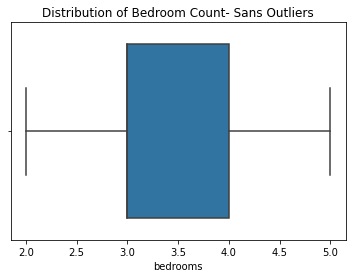

In [20]:
#NOW visualize bedroom count after outliers were dropped 
sns.boxplot(zillow.bedrooms)
plt.title('Distribution of Bedroom Count- Sans Outliers')
plt.show()

In [21]:
#take a look at our target
zillow.logerror.describe()

count    48646.000000
mean         0.016453
std          0.168115
min         -4.655420
25%         -0.025060
50%          0.006019
75%          0.038153
max          3.394544
Name: logerror, dtype: float64

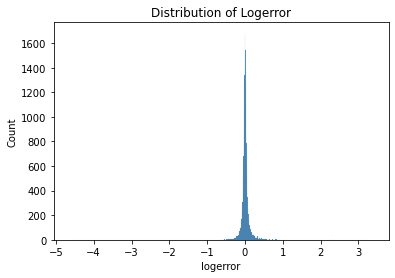

In [22]:
#taxvalue with outliers removed
sns.histplot(data=zillow.logerror)
plt.title('Distribution of Logerror')
plt.show()

In [23]:
zillow = zillow.drop(columns=('county'))

In [24]:
zillow.head()

,parcelid,logerror,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,property_age
0,14297519,0.025595,3.5,4,3100,6059,33634931,-117869207,4506,96978,1998,485713,1023282,537569,11013,20170101,19
1,17052889,0.055619,1.0,2,1465,6111,34449266,-119281531,12647,97099,1967,88000,464000,376000,5672,20170101,50
2,14186244,0.005383,2.0,3,1243,6059,33886168,-117823170,8432,97078,1962,85289,564778,479489,6488,20170101,55
3,12177905,-0.103410,3.0,4,2376,6037,34245180,-118240722,13038,96330,1970,108918,145143,36225,1777,20170101,47
4,12095076,-0.001011,3.0,4,2962,6037,34145202,-118179824,63000,96293,1950,276684,773303,496619,9516,20170101,67


### Split data

In [25]:
train, validate, test = prepare.simple_split(zillow)

train -> (27241, 17)
validate -> (11675, 17)
test -> (9730, 17)


In [26]:
#train validate test split
#split data using zillow_split function from prepare.py
X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.zillow_split(zillow, 'logerror')

In [27]:
#take a look at X_train
X_train.head()

,parcelid,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,property_age
4117,11296376,2.0,3,1384,6037,34703526,-118101120,5803,97318,1989,71286,92216,20930,1962,20170127,28
28813,12476553,2.0,3,1215,6037,33869841,-118127946,6570,96208,1952,99505,185287,85782,2437,20170601,65
29847,11125066,3.0,4,2511,6037,34447711,-118471283,9195,96373,2013,342761,549867,207106,7157,20170606,4
47242,17073351,1.5,3,1040,6111,34309700,-119289721,8395,97081,1963,38452,51864,13412,596,20170823,54
29768,12249440,4.0,5,2520,6037,33884382,-118296847,6759,96104,1926,197342,388191,190849,4828,20170606,91


### Scale data

In [28]:
numeric_cols = ['bathrooms', 'bedrooms', 'total_sqft', 'county_code',
       'latitude', 'longitude', 'lotsizesquarefeet', 'regionidzip',
       'year_built', 'structuretaxvaluedollarcnt', 'value_assessed',
       'landtaxvaluedollarcnt', 'tax_amount',
       'property_age']

In [29]:
#use min_max_scaler function from prepare.py
X_train_scaled, X_validate_scaled, X_test_scaled = prepare.min_max_scaler(X_train, X_validate, X_test, numeric_cols)

In [30]:
#take a look!
X_train_scaled

,parcelid,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,property_age
4117,11296376,0.333333,0.333333,0.333875,0.0,0.922037,0.715488,0.000764,0.004399,0.804348,0.022038,0.008389,0.001891,0.014778,20170127,0.195652
28813,12476553,0.333333,0.333333,0.288076,0.0,0.358030,0.701522,0.000874,0.000744,0.536232,0.030799,0.016949,0.008044,0.018451,20170601,0.463768
29847,11125066,0.666667,0.666667,0.639295,0.0,0.748972,0.522774,0.001250,0.001287,0.978261,0.106321,0.050480,0.019555,0.054952,20170606,0.021739
47242,17073351,0.166667,0.333333,0.240650,1.0,0.655605,0.096677,0.001135,0.003619,0.615942,0.011844,0.004678,0.001178,0.004215,20170823,0.384058
29768,12249440,1.000000,1.000000,0.641734,0.0,0.367867,0.613589,0.000901,0.000402,0.347826,0.061174,0.035611,0.018012,0.036941,20170606,0.652174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52021,11305595,0.333333,0.333333,0.460976,0.0,0.908939,0.669566,0.000821,0.004402,0.818841,0.035080,0.012932,0.002592,0.018552,20170913,0.181159
51957,10714822,0.333333,0.666667,0.436043,0.0,0.591375,0.448747,0.000987,0.001176,0.579710,0.041829,0.035741,0.024058,0.036732,20170913,0.420290
26148,12619470,0.333333,0.666667,0.382656,0.0,0.310910,0.628447,0.000553,0.000813,0.644928,0.014880,0.006056,0.001671,0.010471,20170522,0.355072
34018,12807330,0.000000,0.333333,0.215718,0.0,0.422872,0.731620,0.000704,0.000632,0.521739,0.017281,0.024496,0.019960,0.043360,20170623,0.478261


In [31]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48646 entries, 0 to 52915
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   parcelid                    48646 non-null  int64  
 1   logerror                    48646 non-null  float64
 2   bathrooms                   48646 non-null  float64
 3   bedrooms                    48646 non-null  int64  
 4   total_sqft                  48646 non-null  int64  
 5   county_code                 48646 non-null  int64  
 6   latitude                    48646 non-null  int64  
 7   longitude                   48646 non-null  int64  
 8   lotsizesquarefeet           48646 non-null  int64  
 9   regionidzip                 48646 non-null  int64  
 10  year_built                  48646 non-null  int64  
 11  structuretaxvaluedollarcnt  48646 non-null  int64  
 12  value_assessed              48646 non-null  int64  
 13  landtaxvaluedollarcnt       486

## Takeaways from Prepare 
- several columns were renamed in order to make them more legible
- duplicates were dropped on parcelid
- null values:
    - dropped if they fell outside of the threshold (0.5 column, 0.5 rows)
    - if fell inside the threshold, null values were imputed by 'mean' and 'most frequent'
- outliers were dropped from bedrooms, bathrooms, total_sqft columns
- final dataframe contains 48646 entries with 17 columns 

<hr style="border:2px solid black"> </hr>

## Explore

In [32]:
#function from explore.py
#summary = explore.summarize(zillow)

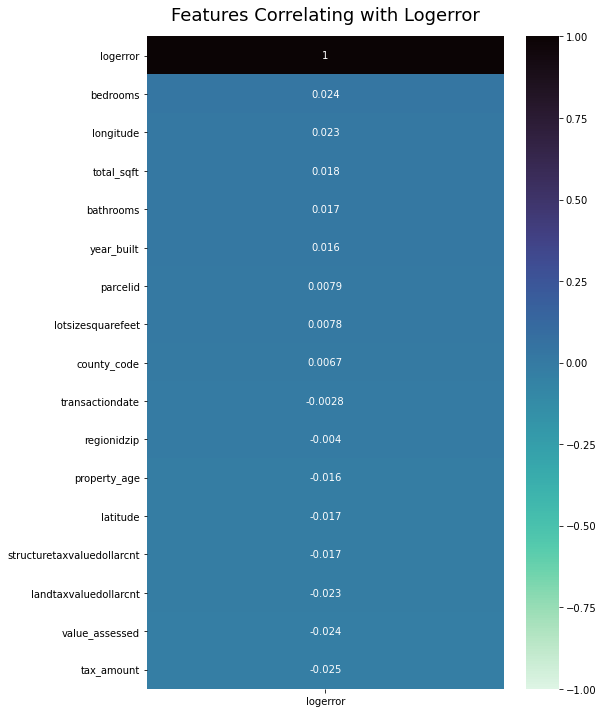

In [33]:
#see what correlates most with logerror
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(zillow.corr()[['logerror']].sort_values(by='logerror', ascending=False), vmin=-1, vmax=1, annot=True, cmap='mako_r')
heatmap.set_title('Features Correlating with Logerror', fontdict={'fontsize':18}, pad=16);

### Feature Engineering

In [34]:
# use RFE to find best features for analysis

X = X_train[list(X_train.select_dtypes(exclude=['object']).columns)]
y = y_train

#create model
lm = LinearRegression()
#select hyperparameters
rfe = RFE(estimator=lm, n_features_to_select=3)
#fit model
rfe.fit(X, y)

X.columns[rfe.support_]

Index(['year_built', 'value_assessed', 'property_age'], dtype='object')

In [35]:
#make easier to read
pd.Series(dict(zip(X.columns, rfe.ranking_))).sort_values()

year_built                     1
value_assessed                 1
property_age                   1
landtaxvaluedollarcnt          2
structuretaxvaluedollarcnt     3
lotsizesquarefeet              4
tax_amount                     5
total_sqft                     6
regionidzip                    7
longitude                      8
bedrooms                       9
latitude                      10
bathrooms                     11
county_code                   12
transactiondate               13
parcelid                      14
dtype: int64

___________

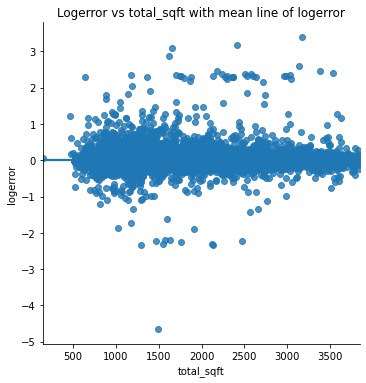

In [36]:
#visualize Log error vs total_sqft
sns.lmplot(x='total_sqft', y='logerror', data=train)
plt.title('Logerror vs total_sqft with mean line of logerror')
plt.show()

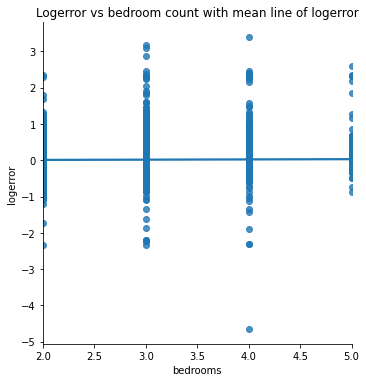

In [37]:
#visualize log error vs bedroom count
sns.lmplot(x='bedrooms', y='logerror', data=train)
plt.title('Logerror vs bedroom count with mean line of logerror')
plt.show()

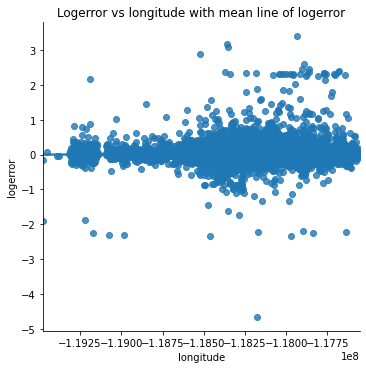

In [38]:
#visualize log error vs longitude
sns.lmplot(x='longitude', y='logerror', data=train)
plt.title('Logerror vs longitude with mean line of logerror')
plt.show()

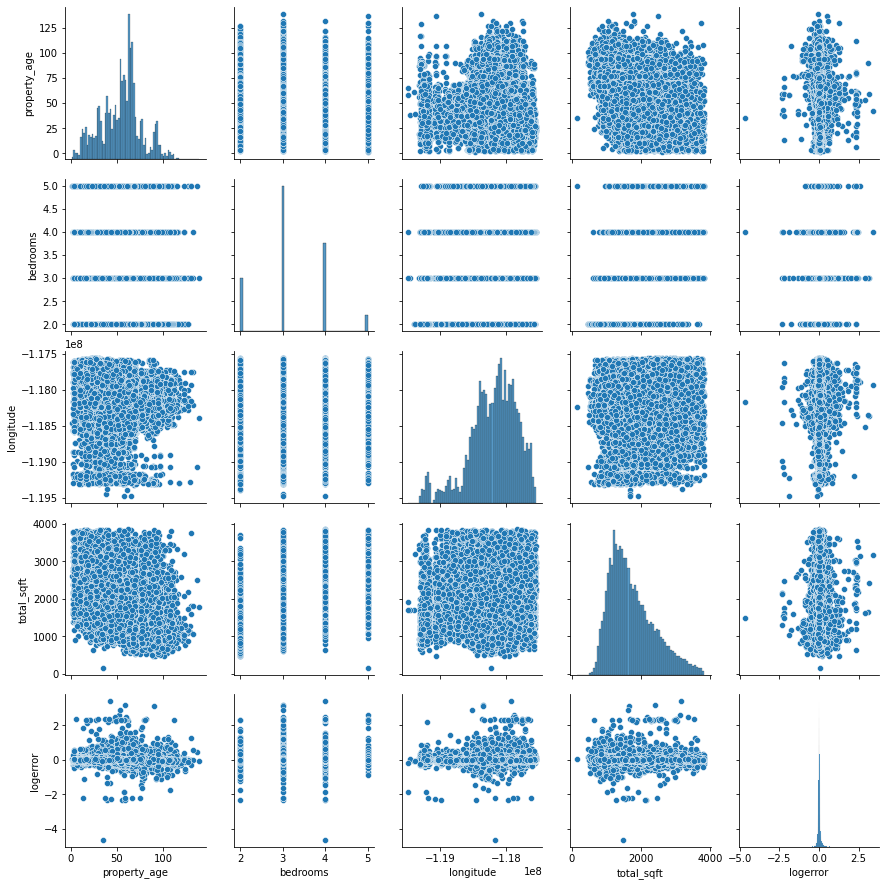

In [39]:
#create pairplot by county in train dataset
cols = ['property_age', 'bedrooms', 'longitude', 'total_sqft', 'logerror']

sns.pairplot(data = train[cols])
plt.show()

### Takeaways:
- there appears to be something going on between logerror and age of property

_______________________

## Hypothesis Testing:

- correlation testing: tests 2 continuous variables
- pearsons looks to find if two sample have a **linear** relationship
- r, p = stats.pearsonsr(x,y)

<br>

- T-Test: tests a continuous and a discrete variable
- t, p = stats.ttest_ind(x,y, equal_var= )


### Hypothesis 1: Correlation Test (Sqft vs Logerror)
- $H_0$: There is no correlation between logerror and total square feet of the property
- $H_a$: There is a correlation between logerror and total square feet of the property

In [40]:
#set alpha
alpha = .05

r, p = stats.pearsonr(train.logerror, train.total_sqft)
print('r-value:',round(r,4),'p-value:',round(p,4))

r-value: 0.0226 p-value: 0.0002


In [41]:
if p <alpha: 
    print('We fail to reject null hypothesis. There is a relationshiop between logerror and total square feet')
else:
    print('We reject our null hypothesis. There is no relationshiop between logerror and total square feet')

We fail to reject null hypothesis. There is a relationshiop between logerror and total square feet


_____________________________

### Hypothesis 2: Correlation Test (Logerror vs Property_Age)
- $H_0$: There is no correlation between logerror and age of the property
- $H_a$: There is a correlation between logerror and age of the property

In [42]:
#set alpha
alpha = .05

r, p = stats.pearsonr(train.logerror, train.property_age)
print('r-value:',round(r,4),'p-value:',round(p,4))

r-value: -0.0145 p-value: 0.0167


In [43]:
if p <alpha: 
    print('We fail to reject null hypothesis. There is a relationshiop between logerror and age of the property')
else:
    print('We reject our null hypothesis. There is no relationshiop between logerror and age of the property')

We fail to reject null hypothesis. There is a relationshiop between logerror and age of the property


____________________

### Hypothesis 3: Correlation Test (Longitude vs Logerror)
- $H_0$: There is no correlation between logerror and longitude
- $H_a$: There is a correlation between logerror and longitude

In [44]:
#set alpha
alpha = .05
#r,p = stats.pearsonsr(x,y)
r, p = stats.pearsonr(train.logerror, train.longitude)

print('r-value:',round(r,4),'p-value:',round(p,4))

r-value: 0.0273 p-value: 0.0


In [45]:
if p <alpha: 
    print('We fail to reject null hypothesis. There is a relationshiop between logerror and longitude')
else:
    print('We reject our null hypothesis. There is no relationshiop between logerror and longitude')

We fail to reject null hypothesis. There is a relationshiop between logerror and longitude


_____________________

### Hypothesis 4: T-Test (Bedrooms vs Logerror)
- $H_0$: There is no relationship between logerror and bedroom count
- $H_a$: There is a relationship between logerror and bedroom count

In [46]:
#set alpha
alpha = .05

In [47]:
# sample size, must be more then 30 to meet assumption
train.logerror.count(), train.bedrooms.count()

(27241, 27241)

In [48]:
#check variance
train.value_assessed.var(), train.bedrooms.var()

#this shows not equal varient

(177779642409.21225, 0.6315144917657536)

In [49]:
#t-test on entire train set
t, p = stats.ttest_ind(train.bedrooms,train.logerror, equal_var=False)

print('t-value:',round(t,4),'p-value:',round(p,4))

t-value: 651.8356 p-value: 0.0


In [50]:
if p <alpha: 
    print('We fail to reject null hypothesis. There is a relationshiop between logerror and number of bedrooms')
else:
    print('We reject our null hypothesis. There is no relationshiop between logerror and number of bedrooms')

We fail to reject null hypothesis. There is a relationshiop between logerror and number of bedrooms


### Takeaways from Hypothesis Testing:
- We have failed to reject all four $H_0$. 
- There are relationships between these features and logerror.

<hr style="border:2px solid black"> </hr>

________________________

## Clustering

### Brainstorm about clusters:
- **WHAT** is logerror??
    - predicted sale value being different from actual sale value

<br>
 
- reasons **WHY** logerror may exist...
    - age of property
    - location of property
    - number of rooms
    - square feet of the property

### Cluster #1

In [51]:
#chose variables for this possible cluster
X = train[['longitude', 'total_sqft']]
#tke a look
X.head()

,longitude,total_sqft
4117,-118101120,1384
28813,-118127946,1215
29847,-118471283,2511
47242,-119289721,1040
29768,-118296847,2520


In [52]:
# Scale the X
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

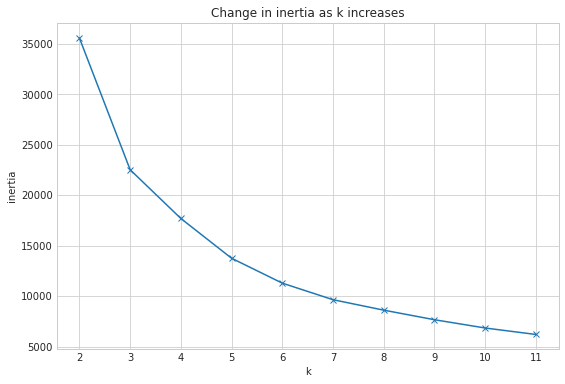

In [53]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

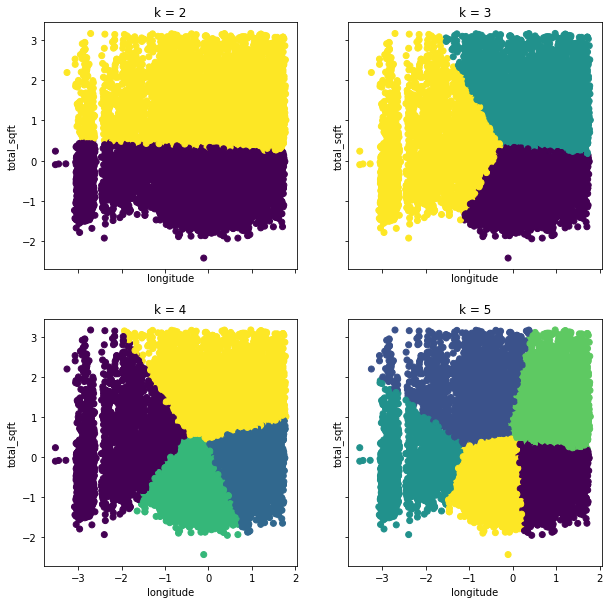

In [54]:
#use scatter_plot function from explore.py
#this will show you different clusters with varying k values
explore.scatter_plots(X_scaled, col_name= 'longitude', col_name_two= 'total_sqft')

In [55]:
#use create_cluster function from explore.py
train, X_scaled, scaler, kmeans, centroids_scaled = explore.create_cluster(train, X, 5, col_name= 'cluster_longitude_totalsqft')

In [56]:
#take a look at the new column
train.head()

,parcelid,logerror,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,property_age,cluster_longitude_totalsqft
4117,11296376,0.001174,2.0,3,1384,6037,34703526,-118101120,5803,97318,1989,71286,92216,20930,1962,20170127,28,0
28813,12476553,0.091318,2.0,3,1215,6037,33869841,-118127946,6570,96208,1952,99505,185287,85782,2437,20170601,65,0
29847,11125066,-0.010416,3.0,4,2511,6037,34447711,-118471283,9195,96373,2013,342761,549867,207106,7157,20170606,4,1
47242,17073351,-0.040713,1.5,3,1040,6111,34309700,-119289721,8395,97081,1963,38452,51864,13412,596,20170823,54,2
29768,12249440,0.050421,4.0,5,2520,6037,33884382,-118296847,6759,96104,1926,197342,388191,190849,4828,20170606,91,1


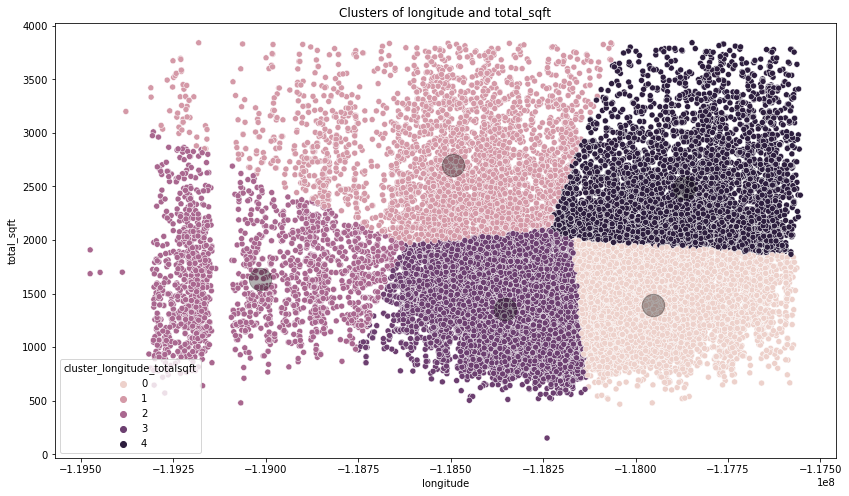

In [57]:
#plot only k=5
plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'longitude', y = 'total_sqft', data = train, hue = 'cluster_longitude_totalsqft')
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
centroids.plot.scatter(y='total_sqft', x= 'longitude', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of longitude and total_sqft')
plt.show()

### Cluster #1 Takeaways:

- inertia seems to be flattening out around k=5

- **cluster_0**: longitude between -1.18 to -1.175 and sqft of ~500 to ~2000  

- **cluster_1**: longitude between -1.194 to -1.18 and sqft of ~2000 to ~3800  

- **cluster_2**: longitude between -1.1950 to -1.186 and sqft of ~500 to ~3000 (least grouped together in my opinion)

- **cluster_3**: longitude between -1.1875 to -1.1826 and sqft of ~100 to ~2000 (smallest properties) 

- **cluster_4**: longitude between -1.1825 to -1.1750 and sqft of ~2000 to ~3800  

____________________

## Cluster #2

In [58]:
#chose variables for this possible cluster
X2 = train[['property_age', 'total_sqft']]
#take a look
X2.head()

,property_age,total_sqft
4117,28,1384
28813,65,1215
29847,4,2511
47242,54,1040
29768,91,2520


In [59]:
# Scale the X
scaler = StandardScaler().fit(X2)
X2_scaled = pd.DataFrame(scaler.transform(X2), columns= X2.columns).set_index([X2.index.values])

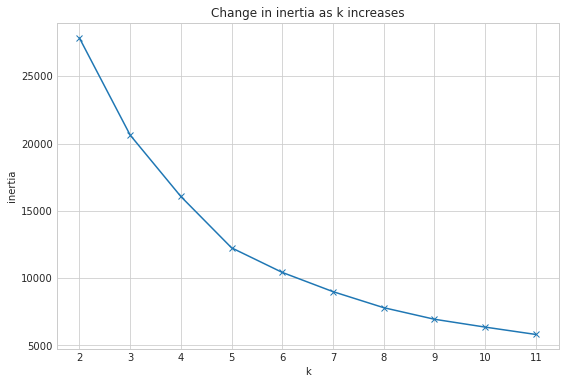

In [60]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X2_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

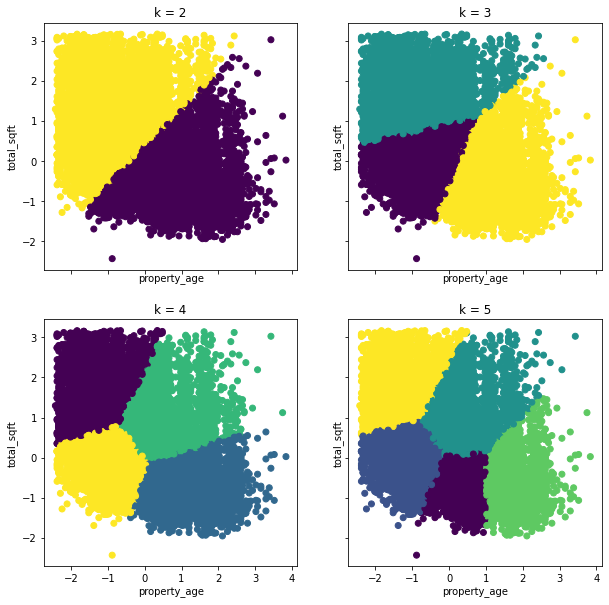

In [61]:
#use scatter_plots function from explore.py
#this will show you different clusters with varying k values
explore.scatter_plots(X2_scaled, col_name= 'property_age', col_name_two= 'total_sqft')

In [62]:
#use create_cluster function from explore.py
train, X2_scaled, scaler, kmeans, centroids_scaled = explore.create_cluster(train, X2, 3, col_name= 'cluster_age_totalsqft')

In [63]:
#take a look at the new column
train.head()

,parcelid,logerror,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,property_age,cluster_longitude_totalsqft,cluster_age_totalsqft
4117,11296376,0.001174,2.0,3,1384,6037,34703526,-118101120,5803,97318,1989,71286,92216,20930,1962,20170127,28,0,2
28813,12476553,0.091318,2.0,3,1215,6037,33869841,-118127946,6570,96208,1952,99505,185287,85782,2437,20170601,65,0,1
29847,11125066,-0.010416,3.0,4,2511,6037,34447711,-118471283,9195,96373,2013,342761,549867,207106,7157,20170606,4,1,0
47242,17073351,-0.040713,1.5,3,1040,6111,34309700,-119289721,8395,97081,1963,38452,51864,13412,596,20170823,54,2,1
29768,12249440,0.050421,4.0,5,2520,6037,33884382,-118296847,6759,96104,1926,197342,388191,190849,4828,20170606,91,1,1


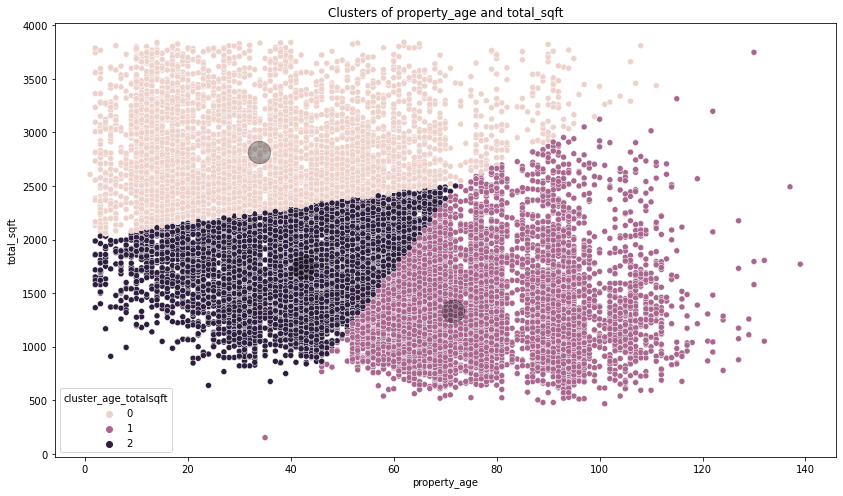

In [64]:
#plot only k=3
plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'property_age', y = 'total_sqft', data = train, hue = 'cluster_age_totalsqft')
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X2_scaled.columns)
centroids.plot.scatter(y='total_sqft', x= 'property_age', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of property_age and total_sqft')
plt.show()

### Cluster #2 Takeaways:

- **cluster_0**: The Largest Sqft 
    - most vast range for age of property (between 0 to ~120 years old)
    - Sqft of property all above 2000 sqft. Largest properties

<br>

- **cluster_1**: Older & Smaller
    - age of property between ~50 to ~120 years old (with some outliers). Oldest homes
    - Sqft of ~500 to ~2500 (with some outliers)  

<br>

- **cluster_2**: Smallest & newest
    - age of property between 0 year to 70 years. 
    - Sqft of ~500 to ~2250. 


______________________

## Cluster #3

In [65]:
#chose variables for this possible cluster
X3 = train[['bedrooms', 'property_age']]
#tke a look
X3.head()

,bedrooms,property_age
4117,3,28
28813,3,65
29847,4,4
47242,3,54
29768,5,91


In [66]:
# Scale the X
scaler = StandardScaler().fit(X3)
X3_scaled = pd.DataFrame(scaler.transform(X3), columns= X3.columns).set_index([X3.index.values])

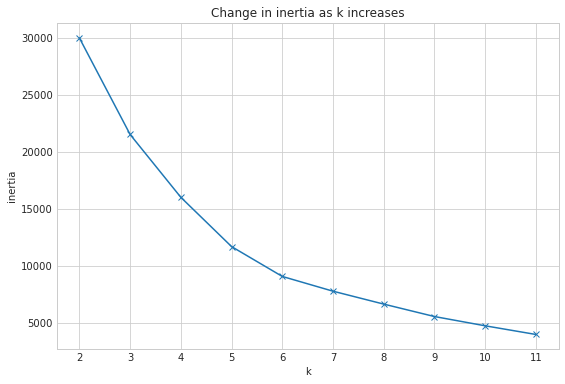

In [67]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X3_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

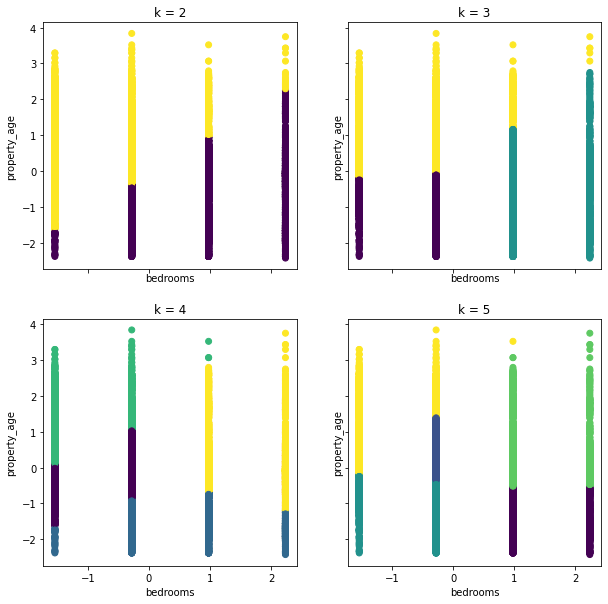

In [68]:
#use scatter_plots function from explore.py
#this will show you different clusters with varying k values
explore.scatter_plots(X3_scaled, col_name= 'bedrooms', col_name_two= 'property_age')

In [69]:
#use create_cluster function from explore.py
train, X3_scaled, scaler, kmeans, centroids_scaled = explore.create_cluster(train, X3, 4, col_name= 'cluster_age_bedrooms')

In [70]:
#take a look at the new column
train.head()

,parcelid,logerror,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,property_age,cluster_longitude_totalsqft,cluster_age_totalsqft,cluster_age_bedrooms
4117,11296376,0.001174,2.0,3,1384,6037,34703526,-118101120,5803,97318,1989,71286,92216,20930,1962,20170127,28,0,2,2
28813,12476553,0.091318,2.0,3,1215,6037,33869841,-118127946,6570,96208,1952,99505,185287,85782,2437,20170601,65,0,1,1
29847,11125066,-0.010416,3.0,4,2511,6037,34447711,-118471283,9195,96373,2013,342761,549867,207106,7157,20170606,4,1,0,2
47242,17073351,-0.040713,1.5,3,1040,6111,34309700,-119289721,8395,97081,1963,38452,51864,13412,596,20170823,54,2,1,1
29768,12249440,0.050421,4.0,5,2520,6037,33884382,-118296847,6759,96104,1926,197342,388191,190849,4828,20170606,91,1,1,0


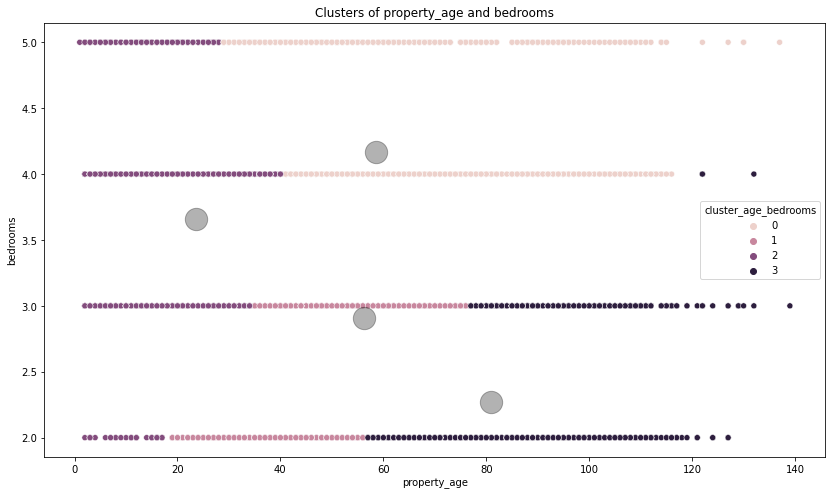

In [71]:
#plot only k=4
plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'property_age', y = 'bedrooms', data = train, hue = 'cluster_age_bedrooms')
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X3_scaled.columns)
centroids.plot.scatter(y='bedrooms', x= 'property_age', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of property_age and bedrooms')
plt.show()

### Cluster #3 Takeaways:

- **cluster_0**: The biggies
    - all have 4 or 5 bedrooms
    - 25 years old to 140 years old

<br>

- **cluster_1**: Middle of the road
    - all have 2 or 3 bedrooms
    - 20 years old to 80 years old 

<br>

- **cluster_2**: The youngsters
    - have largest range of bedrooms (2-5)
    - 0 years old to 40 years old
    
<br>

- **cluster_3**: The Oldies
    - have 2 or 3 bedrooms (except 2)
    - ~58 years old to 140 years old

<hr style="border:2px solid black"> </hr>

# Model

In [72]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame({'actual': y_train})
y_validate = pd.DataFrame({'actual': y_validate})
y_test = pd.DataFrame({'actual': y_test})

## Create Baseline

In [73]:
#create the baseline
baseline= y_train['actual'].mean()

In [74]:
#create column called baseline to compare
y_train['baseline'] = baseline

In [75]:
#calculate RMSE for baseline model
rmse_baseline_train= math.sqrt(mean_squared_error(y_train.actual, y_train.baseline))

In [76]:
# predict validate
y_validate['baseline'] = baseline

# evaluate: rmse
rmse_baseline_validate = math.sqrt(mean_squared_error(y_validate.actual, y_validate.baseline))

In [77]:
#create a dataframe to make data easier to visualize/understand
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_train': round(rmse_baseline_train, 5),
    'rmse_validate': round(rmse_baseline_validate, 5)
}])

metric_df
#we now have out baseline model to work off of

,model,rmse_train,rmse_validate
0,mean_baseline,0.16529,0.17102


In [78]:
#set features
#we do not want to include all columns in this because it could cause overfitting
features = ['property_age', 'total_sqft', 'bedrooms']

In [96]:
featurescluster = ['property_age', 'total_sqft', 'bedrooms','cluster_age_totalsqft']

__________________

## Model #1: OLS 

In [79]:
#ordinary least squares
#create the model 
model1 = LinearRegression(normalize=True)

#fit the model
model1.fit(X_train_scaled[features], y_train.actual)

LinearRegression(normalize=True)

In [80]:
# predict train
y_train['logerror_pred_lm'] = model1.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = model1.predict(X_validate_scaled[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lm)**(1/2)

In [81]:
#create visual to see baseline vs LinearRegression model
metric_df = metric_df.append(
    {
    'model': 'Model 1: OLS',
    'rmse_train': round(rmse_train, 5),
    'rmse_validate': round(rmse_validate,5),
    }, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate
0,mean_baseline,0.16529,0.17102
1,Model 1: OLS,0.16520,0.17103


__________________________

## Model #2: Lasso Lars

In [82]:
# create the model object
model2 = LassoLars(alpha= 2)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
model2.fit(X_train_scaled[features], y_train.actual)

# predict train
y_train['logerror_pred_lars'] = model2.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_lars)**(1/2)

# predict validate
y_validate['logerror_pred_lars'] = model2.predict(X_validate_scaled[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lars)**(1/2)

In [83]:
#shows baseline vs LinearRegression vs LassoLars
metric_df = metric_df.append(
    {
    'model': 'Model 2: LassoLars (alpha 2)',
    'rmse_train': round(rmse_train,5),
    'rmse_validate': round(rmse_validate,5),
    }, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate
0,mean_baseline,0.16529,0.17102
1,Model 1: OLS,0.16520,0.17103
2,Model 2: LassoLars (alpha 2),0.16529,0.17102


____________________

## Model #3: Polynomial Features

In [94]:
#make the polynomial features to get a new set of features
model3 = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled features
X_train_degree2 = model3.fit_transform(X_train_scaled[features])

# transform X_validate_scaled 
X_validate_degree2 = model3.transform(X_validate_scaled[features])


In [86]:
#create the model
lm2 = LinearRegression(normalize=True)

#fit the mode
lm2.fit(X_train_degree2, y_train.actual)

#use the model
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_model3 = mean_squared_error(y_train.actual, y_train.logerror_pred_lm2) ** (1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate_model3 = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lm2) ** (1/2)

In [87]:
#shows baseline vs LinearRegression vs LassoLars
metric_df = metric_df.append(
    {
    'model': 'Model 3: Polynomial Regression (degree=2)',
    'rmse_train': round(rmse_train_model3,5),
    'rmse_validate': round(rmse_validate_model3,5),
    }, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate
0,mean_baseline,0.16529,0.17102
1,Model 1: OLS,0.16520,0.17103
2,Model 2: LassoLars (alpha 2),0.16529,0.17102
3,Model 3: Polynomial Regression (degree=2),0.16512,0.17101


_______________________

## Model #4: OLS on Unscaled Data

In [88]:
#ordinary least squares
#create the model 
#try on unscaled data
model4 = LinearRegression(normalize=True)

#fit the model
model4.fit(X_train[features], y_train.actual)

LinearRegression(normalize=True)

In [89]:
# predict train
y_train['pred_lm_unscaled'] = model4.predict(X_train[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['pred_lm_unscaled'] = model4.predict(X_validate[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.actual, y_validate.logerror_pred_lm)**(1/2)

In [90]:
#create visual to see baseline vs LinearRegression model
#try on unscaled data
metric_df = metric_df.append(
    {
    'model': 'Model 4: OLS (Unscaled Data)',
    'rmse_train': round(rmse_train, 5),
    'rmse_validate': round(rmse_validate,5),
    }, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate
0,mean_baseline,0.16529,0.17102
1,Model 1: OLS,0.16520,0.17103
2,Model 2: LassoLars (alpha 2),0.16529,0.17102
3,Model 3: Polynomial Regression (degree=2),0.16512,0.17101
4,Model 4: OLS (Unscaled Data),0.16520,0.17103


#### Use test set on Best model

## Takeaways for Modeling:

- Polynomial Regression models performed best (will be used on test dataset)
- LassoLars performed the same as the basline
- OLS models performed the **same** on scaled and unscaled data


<hr style="border:2px solid black"> </hr>

## Utlimate Takeaways:

- negotitation **cannot** be a data point
<br>

- As much as the Zestimate may be accurate... the buyers may negotiate based on **their** perceived value of the property thus dropping the sale value, causing the zestimate to be off and increasing logerror
